In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
opj = os.path.join
import pickle as pkl

from ex_cosmology import p

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# adaptive-wavelets modules
from awd import awd
from awd.mdata.biology import get_dataloader, load_pretrained_model
from awd.awd.utils import get_wavefun, get_2dfilts
from awd.awd.visualize import plot_2dfilts, plot_wavefun

In [ ]:
p.wave = 'db5'
p.J = 4
p.mode = 'zero'
p.init_factor = 0
p.noise_factor = 0.2
p.const_factor = 0
p.num_epochs = 600
p.attr_methods = 'Saliency'

lamWaveloss = 1
p.lamlSum = lamWaveloss
p.lamhSum = lamWaveloss
p.lamL2sum = lamWaveloss
p.lamCMF = lamWaveloss
p.lamConv = lamWaveloss
p.lamL1wave = 0.001
p.lamL1attr = 0.1
p.target = 0

In [ ]:
# load data and model
train_loader, test_loader = get_dataloader(p.data_path,
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# prepare model
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

wt = awd.DWT2d(wave=p.wave, mode=p.mode, J=p.J,
               init_factor=p.init_factor,
               noise_factor=p.noise_factor,
               const_factor=p.const_factor).to(device)
wt.train()

# check if we have multiple GPUs
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
    wt = torch.nn.DataParallel(wt)

# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = awd.get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, lamCMF=p.lamCMF,
                        lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)
trainer = awd.Trainer(model, wt, optimizer, loss_f, target=p.target,
                      use_residuals=True, attr_methods=p.attr_methods, device=device, n_print=5)    

In [ ]:
# run
trainer(train_loader, epochs=p.num_epochs)

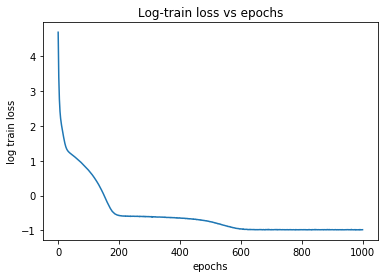

In [61]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [ ]:
print('calculating losses and metric...')
validator = awd.Validator(model, test_loader)
rec_loss, lsum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(
    wt, target=p.target)
print("Recon={:.5f}\n lsum={:.5f}\n hsum={:.5f}\n L2norm={:.5f}\n CMF={:.5f}\n conv={:.5f}\n L1wave={:.5f}\n Saliency={:.5f}\n Inputxgrad={:.5f}\n".format(rec_loss,
                                      lsum_loss,
                                      hsum_loss,
                                      L2norm_loss,
                                      CMF_loss,
                                      conv_loss,
                                      L1wave_loss,
                                      L1saliency_loss,
                                      L1inputxgrad_loss))


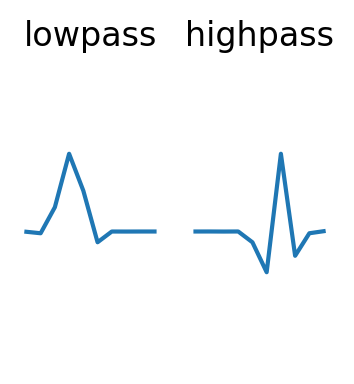

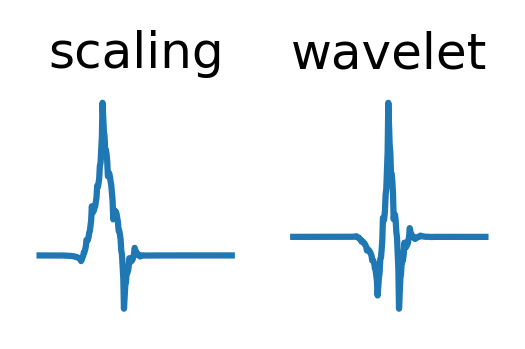

In [63]:
filts = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

plot_1dfilts(filts[0], is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(2,1))